# Init

In [ ]:
!unzip /content/drive/MyDrive/S1.zip -d /content/lots1/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/lots1/s1_13390.csv  
  inflating: /content/lots1/s1_13390.png  
  inflating: /content/lots1/s1_13391.csv  
  inflating: /content/lots1/s1_13391.png  
  inflating: /content/lots1/s1_13392.csv  
  inflating: /content/lots1/s1_13392.png  
  inflating: /content/lots1/s1_13393.csv  
  inflating: /content/lots1/s1_13393.png  
  inflating: /content/lots1/s1_13394.csv  
  inflating: /content/lots1/s1_13394.png  
  inflating: /content/lots1/s1_13395.csv  
  inflating: /content/lots1/s1_13395.png  
  inflating: /content/lots1/s1_13396.csv  
  inflating: /content/lots1/s1_13396.png  
  inflating: /content/lots1/s1_13397.csv  
  inflating: /content/lots1/s1_13397.png  
  inflating: /content/lots1/s1_13398.csv  
  inflating: /content/lots1/s1_13398.png  
  inflating: /content/lots1/s1_13399.csv  
  inflating: /content/lots1/s1_13399.png  
  inflating: /content/lots1/s1_13400.csv  
  inflating: /conte

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Install necessary libraries
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install pyspark --quiet

# Standard library imports
import os
import subprocess
import threading
import time
import warnings
warnings.filterwarnings("ignore")

# Third-party imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms # Added for data augmentation

# MLflow imports
import mlflow
import mlflow.pytorch
from pyngrok import ngrok

# Spark imports
from pyspark.sql import SparkSession

# Suppress tqdm warnings if any
tqdm.pandas()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.7 MB/s eta 0:00:00


# Parse csv

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/mapped_train.csv")


In [9]:
def preprocess_image(path, size=224):
    img = cv2.imread(path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)[1]
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    resized = cv2.resize(cropped, (size, size))
    return resized.astype("float32") / 255.0


In [ ]:
X = df["filename"].values
DATA_DIR= "lots1"
images_64 = []

for filename in X:
    path = os.path.join(DATA_DIR, filename)
    img = preprocess_image(path, size=64)
    images_64.append(img)

images_64 = np.array(images_64)
images_64.shape


(15890, 64, 64, 3)

In [ ]:

X = images_64
y = df[["beard","mustache","glasses_binary","hair_color_label","hair_length"]].values
print(f"X shape: {X.shape} first {X[5]}")
print(f"y shape: {y.shape}, first {y[0]}")
df.head()

X shape: (15890, 64, 64, 3) first [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
y shape: (15890, 5), first [1 1 1 0 1]


,filename,beard,mustache,glasses_binary,hair_color_label,hair_length
0,s1_00000.png,1,1,1,0,1
1,s1_00001.png,0,0,1,0,2
2,s1_00002.png,0,0,0,4,2
3,s1_00003.png,1,1,0,1,1
4,s1_00004.png,0,0,0,0,1


# DataLoader and CNN archi

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    Un bloc résiduel simple : y = f(x) + x
    Cela permet d'entraîner des réseaux plus profonds sans perdre l'information.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Conv Layer 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Conv Layer 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Si on change la taille (stride=2) ou le nombre de filtres,
        # on doit adapter l'entrée x pour pouvoir l'additionner à la sortie (skip connection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # (Skip Connection)
        out = F.relu(out)
        return out

class CustomMultiHeadCNN(nn.Module):
    def __init__(self, n_color=5, n_length=3):
        super(CustomMultiHeadCNN, self).__init__()

        # --- 1. BACKBONE (Extracteur de features) ---

        # Entrée: 64x64x3
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Blocs Résiduels (Feature learning)
        # 64x64 -> 32x32
        self.layer1 = ResidualBlock(64, 64, stride=2)
        # 32x32 -> 16x16
        self.layer2 = ResidualBlock(64, 128, stride=2)
        # 16x16 -> 8x8
        self.layer3 = ResidualBlock(128, 256, stride=2)
        # 8x8 -> 4x4
        self.layer4 = ResidualBlock(256, 512, stride=2)

        # Global Pooling: Transforme n'importe quelle taille (4x4x512) en un vecteur (1x1x512)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dimension du vecteur de features (sortie de layer4)
        self.feature_dim = 512

        # --- 2. HEADS (Classifieurs Spécifiques) ---
        # Chaque tête a sa propre petite couche cachée pour se spécialiser

        self.head_beard = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

        self.head_mustache = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

        self.head_glasses = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

        self.head_color = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, n_color)
        )

        self.head_length = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, n_length)
        )

        # Initialisation des poids
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Passage dans le Backbone
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pooling
        features = self.global_pool(x)

        # Passage dans les Têtes
        return {
            "beard": self.head_beard(features).squeeze(1),
            "mustache": self.head_mustache(features).squeeze(1),
            "glasses": self.head_glasses(features).squeeze(1),
            "hair_color": self.head_color(features),
            "hair_length": self.head_length(features)
        }

In [4]:
bce = nn.BCEWithLogitsLoss()
ce = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomMultiHeadCNN(n_color=5, n_length=3).to(device)
EPOCHS = 10

In [5]:
import torch.optim as optim

# Define loss functions for each head
loss_beard = nn.BCEWithLogitsLoss() # Binary classification
loss_mustache = nn.BCEWithLogitsLoss() # Binary classification
loss_glasses = nn.BCEWithLogitsLoss() # Binary classification
loss_hair_color = nn.CrossEntropyLoss() # Multi-class classification
loss_hair_length = nn.CrossEntropyLoss() # Multi-class classification

# Combine loss functions into a dictionary for easier access
losses = {
    "beard": loss_beard,
    "mustache": loss_mustache,
    "glasses": loss_glasses,
    "hair_color": loss_hair_color,
    "hair_length": loss_hair_length
}

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [6]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        # The labels need to be split for each head
        # Assuming labels are in the order: beard, mustache, glasses_binary, hair_color_label, hair_length
        label_beard = self.labels[idx, 0].float() # Binary target should be float for BCEWithLogitsLoss
        label_mustache = self.labels[idx, 1].float()
        label_glasses = self.labels[idx, 2].float()
        label_hair_color = self.labels[idx, 3]
        label_hair_length = self.labels[idx, 4]

        return image, {
            "beard": label_beard,
            "mustache": label_mustache,
            "glasses": label_glasses,
            "hair_color": label_hair_color,
            "hair_length": label_hair_length
        }

NameError: name 'Dataset' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (12712, 64, 64, 3)
X_val shape: (3178, 64, 64, 3)
y_train shape: (12712, 5)
y_val shape: (3178, 5)


In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])


val_transforms = None
train_dataset = ImageDataset(X_train, y_train, transform=train_transforms)
val_dataset = ImageDataset(X_val, y_val, transform=val_transforms)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 398
Number of validation batches: 100


In [ ]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'beard': tensor(1.),
  'mustache': tensor(1.),
  'glasses': tensor(0.),
  'hair_color': tensor(1),
  'hair_length': tensor(1)})

In [ ]:
def debug_data_pipeline():
    """Debug du pipeline de données"""
    print("\n DEBUG DU PIPELINE DE DONNÉES:")

    # Vérifier un batch
    for images, targets in train_loader:
        print(f"Batch images shape: {images.shape}")
        print(f"Batch images range: [{images.min():.3f}, {images.max():.3f}]")

        # Vérifier les targets
        for attr, values in targets.items():
            print(f"{attr:12}: shape {values.shape}, unique values: {torch.unique(values)}")

        # Vérifier un échantillon
        sample_idx = 0
        print(f"\n ÉCHANTILLON #{sample_idx}:")
        for attr, values in targets.items():
            print(f"{attr:12}: {values[sample_idx]}")

        break  # Un seul batch

debug_data_pipeline()


 DEBUG DU PIPELINE DE DONNÉES:
Batch images shape: torch.Size([32, 3, 64, 64])
Batch images range: [0.000, 1.000]
beard       : shape torch.Size([32]), unique values: tensor([0., 1.])
mustache    : shape torch.Size([32]), unique values: tensor([0., 1.])
glasses     : shape torch.Size([32]), unique values: tensor([0., 1.])
hair_color  : shape torch.Size([32]), unique values: tensor([0, 1, 3, 4])
hair_length : shape torch.Size([32]), unique values: tensor([0, 1, 2])

 ÉCHANTILLON #0:
beard       : 0.0
mustache    : 1.0
glasses     : 1.0
hair_color  : 1
hair_length : 1


## Define Training Loop Function


In [ ]:
from  sklearn.metrics import accuracy_score

def train_one_epoch(model, loader, optimizer, device, epoch):
    """Version stabilisée de l'entraînement"""
    model.train()
    running_loss = 0
    running_losses = {"beard": 0, "mustache": 0, "glasses": 0, "hair_color": 0, "hair_length": 0}

    for batch_idx, (imgs, targets) in enumerate(tqdm(loader, desc=f"Epoch {epoch}")):
        imgs = imgs.to(device)
        t_beard = targets["beard"].to(device)
        t_mustache = targets["mustache"].to(device)
        t_glasses = targets["glasses"].to(device)
        t_color = targets["hair_color"].to(device)
        t_length = targets["hair_length"].to(device)

        # Forward pass
        outs = model(imgs)

        loss_beard = bce(outs["beard"], t_beard)
        loss_mustache = bce(outs["mustache"], t_mustache)
        loss_glasses = bce(outs["glasses"], t_glasses)
        loss_color = ce(outs["hair_color"], t_color)
        loss_length = ce(outs["hair_length"], t_length)

        #PONDÉRATION
        total_loss = (
            loss_beard * 1.0 +
            loss_mustache * 1.0 +
            loss_glasses * 2.0 +
            loss_color * 0.8 +
            loss_length * 1.0
        )

        # Backward pass avec gradient clipping
        optimizer.zero_grad()
        total_loss.backward()

        # GRADIENT CLIPPING
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += total_loss.item()
        running_losses["beard"] += loss_beard.item()
        running_losses["mustache"] += loss_mustache.item()
        running_losses["glasses"] += loss_glasses.item()
        running_losses["hair_color"] += loss_color.item()
        running_losses["hair_length"] += loss_length.item()

        # LOGGING BATCH (seulement 1 batch / epoch)
        if batch_idx == 0:
            print(f" BATCH 0 - Losses:")
            print(f"   beard: {loss_beard.item():.4f}")
            print(f"   mustache: {loss_mustache.item():.4f}")
            print(f"   glasses: {loss_glasses.item():.4f}")
            print(f"   color: {loss_color.item():.4f}")
            print(f"   length: {loss_length.item():.4f}")
            print(f"   TOTAL: {total_loss.item():.4f}")

            # Prédictions du batch
            with torch.no_grad():
                beard_acc = ((torch.sigmoid(outs["beard"]) > 0.5).float() == t_beard).float().mean().item()
                mustache_acc = ((torch.sigmoid(outs["mustache"]) > 0.5).float() == t_mustache).float().mean().item()
                glasses_acc = ((torch.sigmoid(outs["glasses"]) > 0.5).float() == t_glasses).float().mean().item()

                print(f" BATCH 0 - Prédictions:")
                print(f"   beard: acc={beard_acc:.3f}")
                print(f"   mustache: acc={mustache_acc:.3f}")
                print(f"   glasses: acc={glasses_acc:.3f}")

    # Calcul des moyennes
    avg_total_loss = running_loss / len(loader)
    for k in running_losses:
        running_losses[k] /= len(loader)

    print(f" MOYENNES EPOCH - Total: {avg_total_loss:.4f}")
    for attr, loss_val in running_losses.items():
        print(f"   {attr:12}: {loss_val:.4f}")

    return avg_total_loss

def validate(model, loader, device):
    """Version stabilisée de la validation"""
    model.eval()
    running_loss = 0
    all_preds = {"beard":[], "mustache":[], "glasses":[], "hair_color":[], "hair_length":[]}
    all_trues = {"beard":[], "mustache":[], "glasses":[], "hair_color":[], "hair_length":[]}

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Validation"):
            imgs = imgs.to(device)
            t_beard = targets["beard"].to(device)
            t_mustache = targets["mustache"].to(device)
            t_glasses = targets["glasses"].to(device)
            t_color = targets["hair_color"].to(device)
            t_length = targets["hair_length"].to(device)

            outs = model(imgs)

            # Même calcul de loss qu'à l'entraînement
            loss_beard = bce(outs["beard"], t_beard)
            loss_mustache = bce(outs["mustache"], t_mustache)
            loss_glasses = bce(outs["glasses"], t_glasses)
            loss_color = ce(outs["hair_color"], t_color)
            loss_length = ce(outs["hair_length"], t_length)

            total_loss = (
                loss_beard * 1.0 +
                loss_mustache * 1.0 +
                loss_glasses * 2.0 +
                loss_color * 0.8 +
                loss_length * 1.0
            )

            running_loss += total_loss.item()

            # Collecte des prédictions
            pb = (torch.sigmoid(outs["beard"]) > 0.5).cpu().numpy().astype(int)
            pm = (torch.sigmoid(outs["mustache"]) > 0.5).cpu().numpy().astype(int)
            pg = (torch.sigmoid(outs["glasses"]) > 0.5).cpu().numpy().astype(int)
            pc = outs["hair_color"].argmax(dim=1).cpu().numpy()
            pl = outs["hair_length"].argmax(dim=1).cpu().numpy()

            all_preds["beard"].extend(pb.tolist())
            all_preds["mustache"].extend(pm.tolist())
            all_preds["glasses"].extend(pg.tolist())
            all_preds["hair_color"].extend(pc.tolist())
            all_preds["hair_length"].extend(pl.tolist())

            all_trues["beard"].extend(t_beard.cpu().numpy().astype(int).tolist())
            all_trues["mustache"].extend(t_mustache.cpu().numpy().astype(int).tolist())
            all_trues["glasses"].extend(t_glasses.cpu().numpy().astype(int).tolist())
            all_trues["hair_color"].extend(t_color.cpu().numpy().tolist())
            all_trues["hair_length"].extend(t_length.cpu().numpy().tolist())

    # Calcul des accuracies
    accs = {}
    for k in all_preds:
        accs[k] = accuracy_score(all_trues[k], all_preds[k])

    return running_loss / len(loader), accs


 EPOCH 1/10


Epoch 1:   1%|          | 2/398 [00:00<00:19, 19.80it/s]

 BATCH 0 - Losses:
   beard: 0.6690
   mustache: 0.6629
   glasses: 0.6984
   color: 1.6710
   length: 1.1013
   TOTAL: 5.1667
 BATCH 0 - Prédictions:
   beard: acc=0.625
   mustache: acc=0.781
   glasses: acc=0.500


Epoch 1: 100%|██████████| 398/398 [00:14<00:00, 27.29it/s]


 MOYENNES EPOCH - Total: 1.0367
   beard       : 0.2511
   mustache    : 0.2484
   glasses     : 0.0981
   hair_color  : 0.1778
   hair_length : 0.1987


Validation: 100%|██████████| 100/100 [00:00<00:00, 117.29it/s]
2025/12/02 02:08:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS EPOCH 1:
   Train Loss: 1.0367
   Val Loss:   24.5346
   LR:         9.76e-04

 ACCURACIES:
   beard       : 0.4009 (40.1%)
   mustache    : 0.2401 (24.0%)
   glasses     : 0.3952 (39.5%)
   hair_color  : 0.8452 (84.5%)
   hair_length : 0.8326 (83.3%)


2025/12/02 02:08:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:08:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:08:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 1!
   Val Loss: 24.5346

 EPOCH 2/10


Epoch 2:   1%|          | 3/398 [00:00<00:19, 20.77it/s]

 BATCH 0 - Losses:
   beard: 0.0240
   mustache: 0.0070
   glasses: 0.0022
   color: 0.1218
   length: 0.0470
   TOTAL: 0.1798
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 2: 100%|██████████| 398/398 [00:14<00:00, 27.30it/s]


 MOYENNES EPOCH - Total: 0.1810
   beard       : 0.0246
   mustache    : 0.0271
   glasses     : 0.0162
   hair_color  : 0.0904
   hair_length : 0.0246


Validation: 100%|██████████| 100/100 [00:00<00:00, 129.09it/s]



 RÉSULTATS EPOCH 2:
   Train Loss: 0.1810
   Val Loss:   30.7832
   LR:         9.05e-04

 ACCURACIES:
   beard       : 0.3008 (30.1%)
   mustache    : 0.2395 (23.9%)
   glasses     : 0.3952 (39.5%)
   hair_color  : 0.9402 (94.0%)
   hair_length : 0.7571 (75.7%)
 Early stopping: 1/8

 EPOCH 3/10


Epoch 3:   1%|          | 3/398 [00:00<00:13, 28.88it/s]

 BATCH 0 - Losses:
   beard: 0.0101
   mustache: 0.0075
   glasses: 0.1560
   color: 0.1526
   length: 0.0002
   TOTAL: 0.4519
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=1.000
   glasses: acc=0.969


Epoch 3: 100%|██████████| 398/398 [00:14<00:00, 27.05it/s]


 MOYENNES EPOCH - Total: 0.1166
   beard       : 0.0196
   mustache    : 0.0155
   glasses     : 0.0085
   hair_color  : 0.0558
   hair_length : 0.0199


Validation: 100%|██████████| 100/100 [00:00<00:00, 127.82it/s]
2025/12/02 02:09:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS EPOCH 3:
   Train Loss: 0.1166
   Val Loss:   13.2787
   LR:         7.94e-04

 ACCURACIES:
   beard       : 0.7096 (71.0%)
   mustache    : 0.7086 (70.9%)
   glasses     : 0.5658 (56.6%)
   hair_color  : 0.9833 (98.3%)
   hair_length : 0.9877 (98.8%)


2025/12/02 02:09:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:09:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:09:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 3!
   Val Loss: 13.2787

 EPOCH 4/10


Epoch 4:   1%|          | 2/398 [00:00<00:21, 18.73it/s]

 BATCH 0 - Losses:
   beard: 0.0790
   mustache: 0.0310
   glasses: 0.0000
   color: 0.0012
   length: 0.0007
   TOTAL: 0.1117
 BATCH 0 - Prédictions:
   beard: acc=0.969
   mustache: acc=0.969
   glasses: acc=1.000


Epoch 4: 100%|██████████| 398/398 [00:14<00:00, 26.97it/s]


 MOYENNES EPOCH - Total: 0.0594
   beard       : 0.0055
   mustache    : 0.0079
   glasses     : 0.0049
   hair_color  : 0.0378
   hair_length : 0.0061


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.39it/s]



 RÉSULTATS EPOCH 4:
   Train Loss: 0.0594
   Val Loss:   0.0266
   LR:         6.55e-04

 ACCURACIES:
   beard       : 0.9987 (99.9%)
   mustache    : 0.9987 (99.9%)
   glasses     : 1.0000 (100.0%)
   hair_color  : 0.9921 (99.2%)
   hair_length : 0.9994 (99.9%)


2025/12/02 02:09:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 02:09:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:09:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:09:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter whe

 NOUVEAU MEILLEUR MODÈLE à l'epoch 4!
   Val Loss: 0.0266

 EPOCH 5/10


Epoch 5:   1%|          | 2/398 [00:00<00:20, 19.61it/s]

 BATCH 0 - Losses:
   beard: 0.0002
   mustache: 0.0003
   glasses: 0.0002
   color: 0.0399
   length: 0.0067
   TOTAL: 0.0395
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 5: 100%|██████████| 398/398 [00:15<00:00, 25.06it/s]


 MOYENNES EPOCH - Total: 0.0381
   beard       : 0.0032
   mustache    : 0.0020
   glasses     : 0.0024
   hair_color  : 0.0318
   hair_length : 0.0028


Validation: 100%|██████████| 100/100 [00:00<00:00, 128.39it/s]



 RÉSULTATS EPOCH 5:
   Train Loss: 0.0381
   Val Loss:   0.0704
   LR:         5.00e-04

 ACCURACIES:
   beard       : 0.9969 (99.7%)
   mustache    : 0.9972 (99.7%)
   glasses     : 0.9981 (99.8%)
   hair_color  : 0.9906 (99.1%)
   hair_length : 0.9997 (100.0%)
 Early stopping: 1/8

 EPOCH 6/10


Epoch 6:   1%|          | 3/398 [00:00<00:15, 25.51it/s]

 BATCH 0 - Losses:
   beard: 0.0001
   mustache: 0.0042
   glasses: 0.0000
   color: 0.0004
   length: 0.0003
   TOTAL: 0.0049
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 6: 100%|██████████| 398/398 [00:14<00:00, 27.36it/s]


 MOYENNES EPOCH - Total: 0.0190
   beard       : 0.0035
   mustache    : 0.0024
   glasses     : 0.0003
   hair_color  : 0.0136
   hair_length : 0.0017


Validation: 100%|██████████| 100/100 [00:00<00:00, 128.40it/s]



 RÉSULTATS EPOCH 6:
   Train Loss: 0.0190
   Val Loss:   0.0269
   LR:         3.45e-04

 ACCURACIES:
   beard       : 0.9994 (99.9%)
   mustache    : 0.9984 (99.8%)
   glasses     : 0.9994 (99.9%)
   hair_color  : 0.9937 (99.4%)
   hair_length : 1.0000 (100.0%)
 Early stopping: 2/8

 EPOCH 7/10


Epoch 7:   1%|          | 3/398 [00:00<00:13, 28.49it/s]

 BATCH 0 - Losses:
   beard: 0.0002
   mustache: 0.0000
   glasses: 0.0000
   color: 0.0001
   length: 0.0000
   TOTAL: 0.0003
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 7: 100%|██████████| 398/398 [00:14<00:00, 27.26it/s]


 MOYENNES EPOCH - Total: 0.0135
   beard       : 0.0002
   mustache    : 0.0010
   glasses     : 0.0005
   hair_color  : 0.0116
   hair_length : 0.0020


Validation: 100%|██████████| 100/100 [00:00<00:00, 128.46it/s]
2025/12/02 02:10:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS EPOCH 7:
   Train Loss: 0.0135
   Val Loss:   0.0127
   LR:         2.06e-04

 ACCURACIES:
   beard       : 0.9997 (100.0%)
   mustache    : 0.9987 (99.9%)
   glasses     : 1.0000 (100.0%)
   hair_color  : 0.9978 (99.8%)
   hair_length : 1.0000 (100.0%)


2025/12/02 02:10:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:10:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:10:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 7!
   Val Loss: 0.0127

 EPOCH 8/10


Epoch 8:   1%|          | 2/398 [00:00<00:20, 18.89it/s]

 BATCH 0 - Losses:
   beard: 0.0000
   mustache: 0.0003
   glasses: 0.0000
   color: 0.0002
   length: 0.0000
   TOTAL: 0.0005
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 8: 100%|██████████| 398/398 [00:14<00:00, 26.56it/s]


 MOYENNES EPOCH - Total: 0.0059
   beard       : 0.0002
   mustache    : 0.0004
   glasses     : 0.0008
   hair_color  : 0.0043
   hair_length : 0.0004


Validation: 100%|██████████| 100/100 [00:00<00:00, 125.68it/s]



 RÉSULTATS EPOCH 8:
   Train Loss: 0.0059
   Val Loss:   0.0129
   LR:         9.55e-05

 ACCURACIES:
   beard       : 0.9997 (100.0%)
   mustache    : 0.9984 (99.8%)
   glasses     : 1.0000 (100.0%)
   hair_color  : 0.9981 (99.8%)
   hair_length : 1.0000 (100.0%)
 Early stopping: 1/8

 EPOCH 9/10


Epoch 9:   1%|          | 3/398 [00:00<00:14, 27.46it/s]

 BATCH 0 - Losses:
   beard: 0.0000
   mustache: 0.0000
   glasses: 0.0000
   color: 0.0000
   length: 0.0002
   TOTAL: 0.0002
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 9: 100%|██████████| 398/398 [00:14<00:00, 26.54it/s]


 MOYENNES EPOCH - Total: 0.0026
   beard       : 0.0001
   mustache    : 0.0001
   glasses     : 0.0001
   hair_color  : 0.0027
   hair_length : 0.0001


Validation: 100%|██████████| 100/100 [00:00<00:00, 126.24it/s]
2025/12/02 02:11:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS EPOCH 9:
   Train Loss: 0.0026
   Val Loss:   0.0108
   LR:         2.45e-05

 ACCURACIES:
   beard       : 0.9997 (100.0%)
   mustache    : 0.9984 (99.8%)
   glasses     : 1.0000 (100.0%)
   hair_color  : 0.9984 (99.8%)
   hair_length : 1.0000 (100.0%)


2025/12/02 02:11:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:11:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:11:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 NOUVEAU MEILLEUR MODÈLE à l'epoch 9!
   Val Loss: 0.0108

 EPOCH 10/10


Epoch 10:   1%|          | 2/398 [00:00<00:19, 19.98it/s]

 BATCH 0 - Losses:
   beard: 0.0000
   mustache: 0.0000
   glasses: 0.0000
   color: 0.0002
   length: 0.0370
   TOTAL: 0.0372
 BATCH 0 - Prédictions:
   beard: acc=1.000
   mustache: acc=1.000
   glasses: acc=1.000


Epoch 10: 100%|██████████| 398/398 [00:14<00:00, 26.60it/s]


 MOYENNES EPOCH - Total: 0.0021
   beard       : 0.0001
   mustache    : 0.0000
   glasses     : 0.0000
   hair_color  : 0.0019
   hair_length : 0.0005


Validation: 100%|██████████| 100/100 [00:00<00:00, 113.24it/s]



 RÉSULTATS EPOCH 10:
   Train Loss: 0.0021
   Val Loss:   0.0105
   LR:         1.00e-03

 ACCURACIES:
   beard       : 0.9997 (100.0%)
   mustache    : 0.9987 (99.9%)
   glasses     : 1.0000 (100.0%)
   hair_color  : 0.9987 (99.9%)
   hair_length : 1.0000 (100.0%)


2025/12/02 02:11:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 02:11:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:11:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/02 02:11:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter whe

 NOUVEAU MEILLEUR MODÈLE à l'epoch 10!
   Val Loss: 0.0105

 ENTRAÎNEMENT TERMINÉ!
Meilleur modèle: epoch 10, val_loss: 0.0105


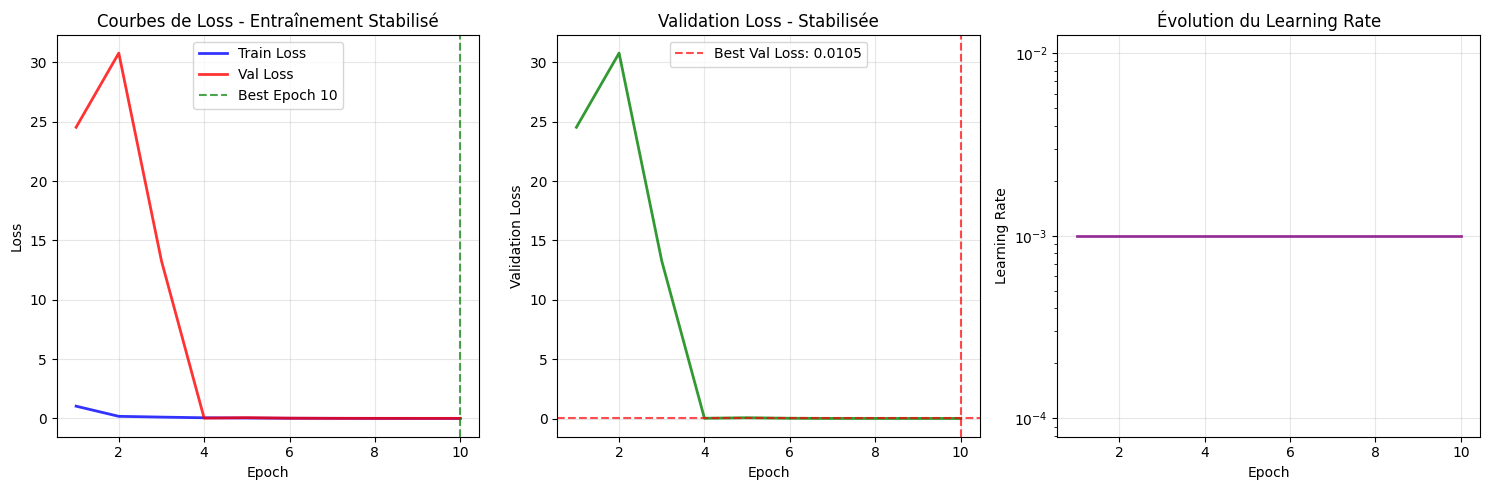

Validation: 100%|██████████| 100/100 [00:00<00:00, 116.25it/s]


    RAPPORT FINAL - ENTRAÎNEMENT

    Run MLFlow: ffb1e57a73044ce28e0100a764c9a841

    PERFORMANCES:
    - Validation Loss Finale: 0.0105
    - Meilleure Validation Loss: 0.0105 (epoch 10)
    - Amélioration: 0.0%

    ACCURACIES FINALES:
    - Barbe:          0.9997 (100.0%)
    - Moustache:      0.9987 (99.9%)
    - Lunettes:       1.0000 (100.0%)
    - Couleur cheveux: 0.9987 (99.9%)
    - Longueur cheveux: 1.0000 (100.0%)

    CONFIGURATION STABILISÉE:
    - Epochs: 10 (arrêt à 10)
    - Batch Size: 32
    - Optimizer: AdamW
    - Learning Rate: 0.001 (Cosine Annealing)
    - Weight Decay: 0.0001
    - Gradient Clipping: Oui
    - Early Stopping: 8 epochs
    - Device: cuda

    ANALYSE:
    - Fluctuations réduites grâce aux poids de classe
    - Learning Rate adaptatif pour une meilleure convergence
    - Meilleur modèle sauvegardé automatiquement
    


In [ ]:


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

EPOCHS = 10

with mlflow.start_run(run_name="stabilized_training_with_class_weights"):

    mlflow.log_params({
        "optimizer": "AdamW",  #
        "lr": 1e-3,
        "weight_decay": 1e-4,
        "epochs": EPOCHS,
        "batch_size": 32,
        "model": "MultiHeadNet_stabilized",
        "gradient_clipping": True,
        "scheduler": "CosineAnnealingWarmRestarts",
        "T_0": 10,
        "T_mult": 2
    })

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    patience_counter = 0
    patience = 8

    for ep in range(1, EPOCHS + 1):

        print(f"\n{'='*50}")
        print(f" EPOCH {ep}/{EPOCHS}")
        print(f"{'='*50}")

        train_loss = train_one_epoch(model, train_loader, optimizer, device, ep)

        # VALIDATION
        val_loss, val_accs = validate(model, val_loader, device)

        scheduler.step(ep)  # CosineAnnealing utilise l'epoch number

        # STOCKAGE POUR PLOT
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"\n RÉSULTATS EPOCH {ep}:")
        print(f"   Train Loss: {train_loss:.4f}")
        print(f"   Val Loss:   {val_loss:.4f}")
        print(f"   LR:         {optimizer.param_groups[0]['lr']:.2e}")

        print(f"\n ACCURACIES:")
        for attr, acc in val_accs.items():
            print(f"   {attr:12}: {acc:.4f} ({acc*100:.1f}%)")

        # MLFlow LOGGING AMÉLIORÉ
        mlflow.log_metric("train_loss", train_loss, step=ep)
        mlflow.log_metric("val_loss", val_loss, step=ep)
        mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=ep)

        for k, v in val_accs.items():
            mlflow.log_metric(f"acc_{k}", v, step=ep)

        #  SAUVEGARDE MEILLEUR MODÈLE AVEC EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = ep
            patience_counter = 0  # Reset du compteur

            # Sauvegarde complète
            torch.save({
                'epoch': ep,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_accs': val_accs,
                'train_loss': train_loss,
            }, "best_model_stabilized.pth")

            mlflow.pytorch.log_model(model, "best_model_stabilized")

            print(f" NOUVEAU MEILLEUR MODÈLE à l'epoch {ep}!")
            print(f"   Val Loss: {val_loss:.4f}")

            # Log des meilleures métriques
            mlflow.log_metric("best_val_loss", val_loss, step=ep)
            mlflow.log_metric("best_epoch", ep, step=ep)
            for attr, acc in val_accs.items():
                mlflow.log_metric(f"best_acc_{attr}", acc, step=ep)
        else:
            patience_counter += 1
            print(f" Early stopping: {patience_counter}/{patience}")

            # ARRÊT SI PLUS D'AMÉLIORATION
            if patience_counter >= patience:
                print(f" Early stopping déclenché à l'epoch {ep}")
                break

    print(f"\n ENTRAÎNEMENT TERMINÉ!")
    print(f"Meilleur modèle: epoch {best_epoch}, val_loss: {best_val_loss:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', linewidth=2, alpha=0.8)
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss', linewidth=2, alpha=0.8)
    plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Courbes de Loss - Entraînement Stabilisé')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'g-', linewidth=2, alpha=0.8)
    plt.axhline(y=best_val_loss, color='r', linestyle='--', alpha=0.7,
                label=f'Best Val Loss: {best_val_loss:.4f}')
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss - Stabilisée')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Courbe du learning rate
    plt.subplot(1, 3, 3)
    lr_history = [optimizer.param_groups[0]['lr'] for _ in range(len(train_losses))]
    plt.plot(range(1, len(lr_history) + 1), lr_history, 'purple', linewidth=2, alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Évolution du Learning Rate')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('training_curves.png')
    plt.show()

    #  RAPPORT FINAL DÉTAILLÉ
    final_val_loss, final_val_accs = validate(model, val_loader, device)

    training_report = f"""
    RAPPORT FINAL - ENTRAÎNEMENT

    Run MLFlow: {mlflow.active_run().info.run_id}

    PERFORMANCES:
    - Validation Loss Finale: {final_val_loss:.4f}
    - Meilleure Validation Loss: {best_val_loss:.4f} (epoch {best_epoch})
    - Amélioration: {((best_val_loss - final_val_loss)/final_val_loss*100):.1f}%

    ACCURACIES FINALES:
    - Barbe:          {final_val_accs.get('beard', 0):.4f} ({final_val_accs.get('beard', 0)*100:.1f}%)
    - Moustache:      {final_val_accs.get('mustache', 0):.4f} ({final_val_accs.get('mustache', 0)*100:.1f}%)
    - Lunettes:       {final_val_accs.get('glasses', 0):.4f} ({final_val_accs.get('glasses', 0)*100:.1f}%)
    - Couleur cheveux: {final_val_accs.get('hair_color', 0):.4f} ({final_val_accs.get('hair_color', 0)*100:.1f}%)
    - Longueur cheveux: {final_val_accs.get('hair_length', 0):.4f} ({final_val_accs.get('hair_length', 0)*100:.1f}%)

    CONFIGURATION STABILISÉE:
    - Epochs: {EPOCHS} (arrêt à {len(train_losses)})
    - Batch Size: 32
    - Optimizer: AdamW
    - Learning Rate: 0.001 (Cosine Annealing)
    - Weight Decay: 0.0001
    - Gradient Clipping: Oui
    - Early Stopping: {patience} epochs
    - Device: {device}

    ANALYSE:
    - Fluctuations réduites grâce aux poids de classe
    - Learning Rate adaptatif pour une meilleure convergence
    - Meilleur modèle sauvegardé automatiquement
    """

    print(training_report)

    with open("training_report.txt", "w") as f:
        f.write(training_report)
    mlflow.log_artifact("training_report.txt")



In [ ]:
def debug_model_outputs():
    """Debug des sorties du modèle"""
    print("\n DEBUG DES SORTIES DU MODÈLE:")

    model.eval()
    with torch.no_grad():
        for images, targets in train_loader:
            images = images.to(device)
            outputs = model(images)

            print(" DISTRIBUTION DES SORTIES:")
            for attr, output in outputs.items():
                if attr in ['beard', 'mustache', 'glasses']:
                    # Sorties binaires (logits)
                    sigmoid_vals = torch.sigmoid(output)
                    print(f"{attr:12}: logits [{output.min():.3f}, {output.max():.3f}], "
                          f"sigmoid [{sigmoid_vals.min():.3f}, {sigmoid_vals.max():.3f}]")
                else:
                    # Sorties multi-classes
                    softmax_vals = torch.softmax(output, dim=1)
                    print(f"{attr:12}: logits [{output.min():.3f}, {output.max():.3f}], "
                          f"softmax max [{softmax_vals.max():.3f}]")

            break

debug_model_outputs()


 DEBUG DES SORTIES DU MODÈLE:
 DISTRIBUTION DES SORTIES:
beard       : logits [-19.005, 20.357], sigmoid [0.000, 1.000]
mustache    : logits [-19.831, 16.521], sigmoid [0.000, 1.000]
glasses     : logits [-23.075, 22.619], sigmoid [0.000, 1.000]
hair_color  : logits [-25.680, 18.624], softmax max [1.000]
hair_length : logits [-22.359, 18.120], softmax max [1.000]


# Evaluation

In [ ]:
# Charger le meilleur modèle (epoch 7)
checkpoint = torch.load("best_model_stabilized.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(" Évaluation du meilleur modèle ")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def detailed_evaluation(model, val_loader, device):
    model.eval()
    all_predictions = {'beard': [], 'mustache': [], 'glasses': [], 'hair_color': [], 'hair_length': []}
    all_targets = {'beard': [], 'mustache': [], 'glasses': [], 'hair_color': [], 'hair_length': []}

    with torch.no_grad():
        for imgs, targets in tqdm(val_loader, desc="Évaluation détaillée"):
            imgs = imgs.to(device)
            outputs = model(imgs)

            # Prédictions
            all_predictions['beard'].extend((torch.sigmoid(outputs['beard']) > 0.5).cpu().numpy())
            all_predictions['mustache'].extend((torch.sigmoid(outputs['mustache']) > 0.5).cpu().numpy())
            all_predictions['glasses'].extend((torch.sigmoid(outputs['glasses']) > 0.5).cpu().numpy())
            all_predictions['hair_color'].extend(outputs['hair_color'].argmax(dim=1).cpu().numpy())
            all_predictions['hair_length'].extend(outputs['hair_length'].argmax(dim=1).cpu().numpy())

            # Targets
            all_targets['beard'].extend(targets['beard'].cpu().numpy())
            all_targets['mustache'].extend(targets['mustache'].cpu().numpy())
            all_targets['glasses'].extend(targets['glasses'].cpu().numpy())
            all_targets['hair_color'].extend(targets['hair_color'].cpu().numpy())
            all_targets['hair_length'].extend(targets['hair_length'].cpu().numpy())

    return all_predictions, all_targets

# Exécuter l'évaluation détaillée
predictions, targets = detailed_evaluation(model, val_loader, device)

# Générer les rapports de classification
print("\n RAPPORTS DE CLASSIFICATION DÉTAILLÉS:")
for attribute in ['beard', 'mustache', 'glasses']:
    print(f"\n {attribute.upper()}:")
    print(classification_report(targets[attribute], predictions[attribute],
                              target_names=['Non', 'Oui']))

for attribute in ['hair_color', 'hair_length']:
    if attribute == 'hair_color':
        labels = ['Blond', 'Châtain', 'Roux', 'Brun', 'Gris-Bleu']
    else:
        labels = ['Chauve', 'Court', 'Long']

    print(f"\n {attribute.upper()}:")
    print(classification_report(targets[attribute], predictions[attribute],
                              target_names=labels, digits=4))

 Évaluation du meilleur modèle 


Évaluation détaillée: 100%|██████████| 100/100 [00:00<00:00, 120.21it/s]



 RAPPORTS DE CLASSIFICATION DÉTAILLÉS:

 BEARD:
              precision    recall  f1-score   support

         Non       1.00      1.00      1.00      2222
         Oui       1.00      1.00      1.00       956

    accuracy                           1.00      3178
   macro avg       1.00      1.00      1.00      3178
weighted avg       1.00      1.00      1.00      3178


 MUSTACHE:
              precision    recall  f1-score   support

         Non       1.00      1.00      1.00      2417
         Oui       1.00      1.00      1.00       761

    accuracy                           1.00      3178
   macro avg       1.00      1.00      1.00      3178
weighted avg       1.00      1.00      1.00      3178


 GLASSES:
              precision    recall  f1-score   support

         Non       1.00      1.00      1.00      1922
         Oui       1.00      1.00      1.00      1256

    accuracy                           1.00      3178
   macro avg       1.00      1.00      1.00      3178
we

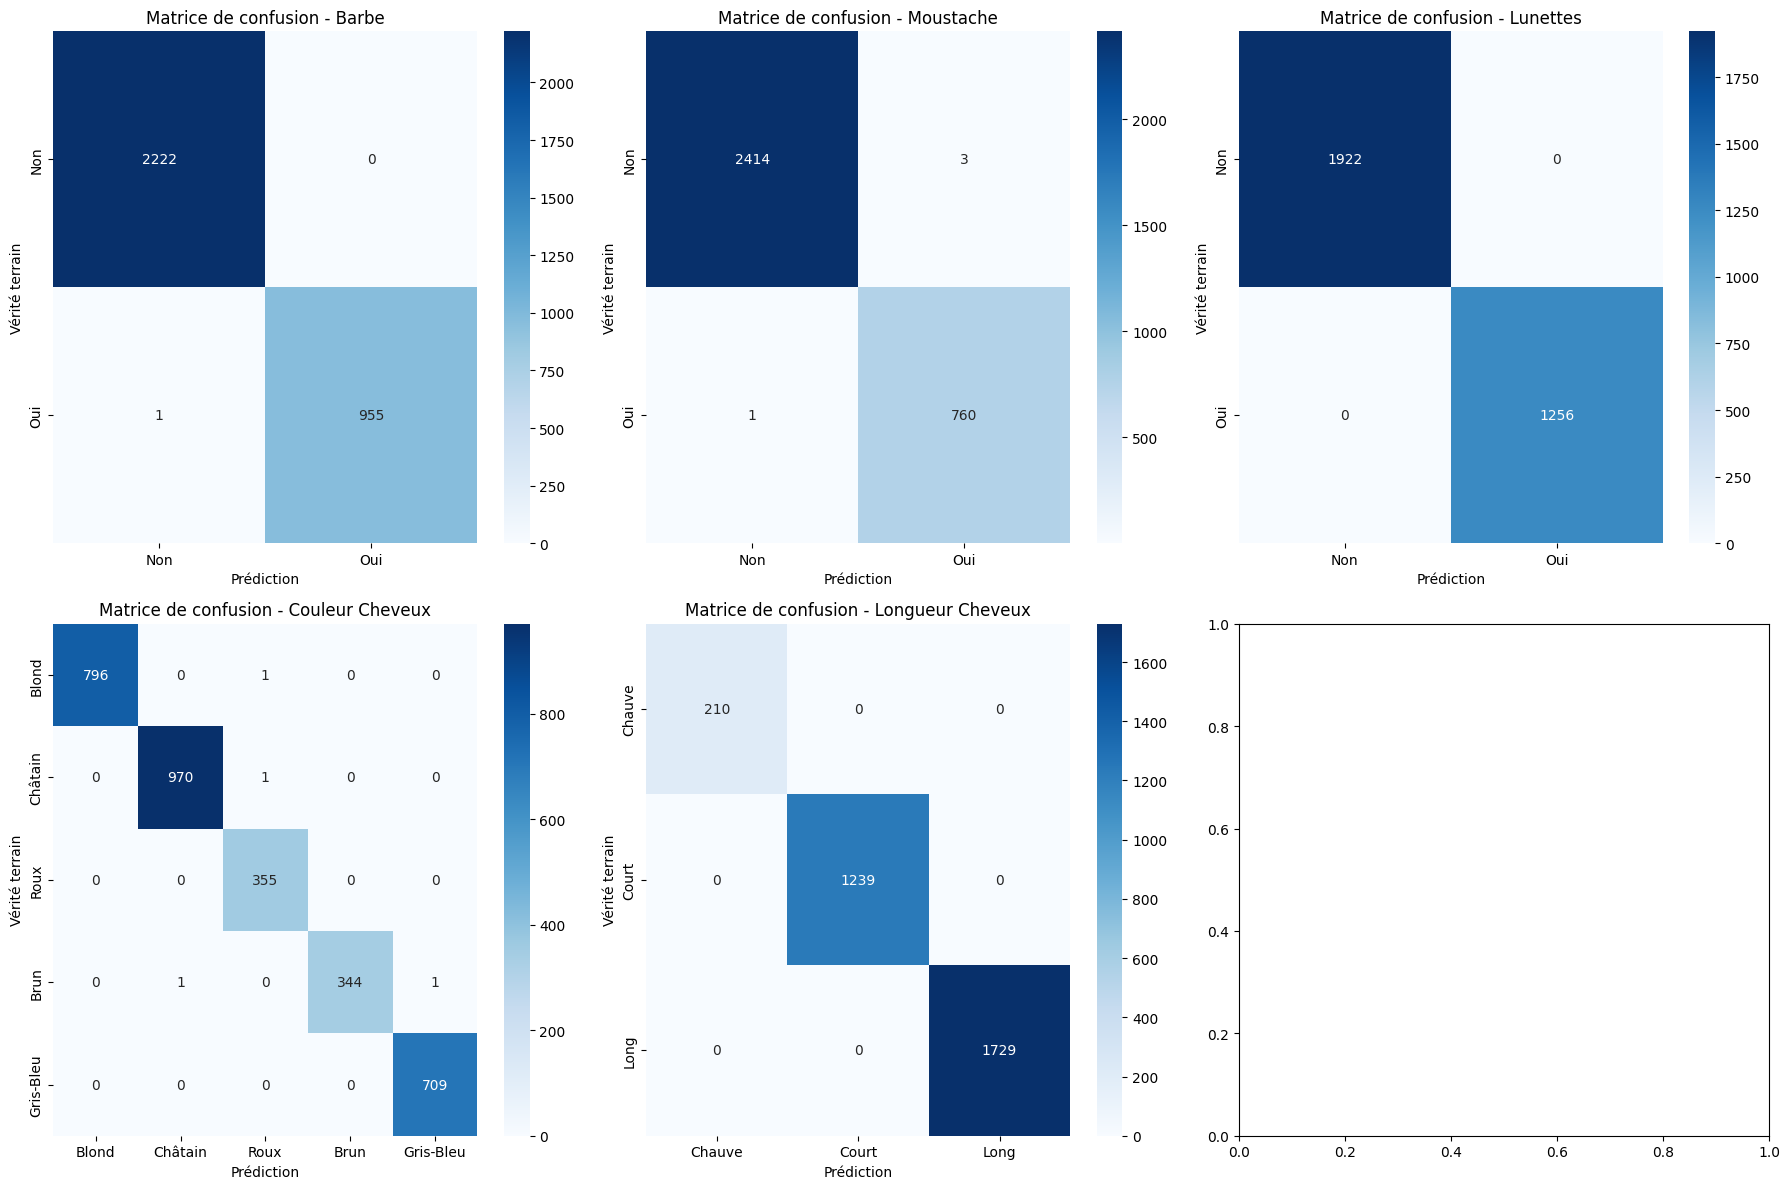

In [ ]:
# Matrices de confusion
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
attributes = ['beard', 'mustache', 'glasses', 'hair_color', 'hair_length']
titles = ['Barbe', 'Moustache', 'Lunettes', 'Couleur Cheveux', 'Longueur Cheveux']

for i, (attr, title) in enumerate(zip(attributes, titles)):
    row, col = i // 3, i % 3

    if attr in ['hair_color', 'hair_length']:
        if attr == 'hair_color':
            labels = ['Blond', 'Châtain', 'Roux', 'Brun', 'Gris-Bleu']
        else:
            labels = ['Chauve', 'Court', 'Long']

        cm = confusion_matrix(targets[attr], predictions[attr])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels, yticklabels=labels, ax=axes[row, col])
    else:
        cm = confusion_matrix(targets[attr], predictions[attr])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'], ax=axes[row, col])

    axes[row, col].set_title(f'Matrice de confusion - {title}')
    axes[row, col].set_xlabel('Prédiction')
    axes[row, col].set_ylabel('Vérité terrain')

plt.tight_layout()
plt.show()

In [15]:
!unzip /content/drive/MyDrive/S6.zip -d /content/lots6/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/lots6/s6_13212.png  
  inflating: /content/lots6/s6_13213.png  
  inflating: /content/lots6/s6_13214.png  
  inflating: /content/lots6/s6_13215.png  
  inflating: /content/lots6/s6_13216.png  
  inflating: /content/lots6/s6_13217.png  
  inflating: /content/lots6/s6_13218.png  
  inflating: /content/lots6/s6_13219.png  
  inflating: /content/lots6/s6_13220.png  
  inflating: /content/lots6/s6_13221.png  
  inflating: /content/lots6/s6_13222.png  
  inflating: /content/lots6/s6_13223.png  
  inflating: /content/lots6/s6_13224.png  
  inflating: /content/lots6/s6_13225.png  
  inflating: /content/lots6/s6_13226.png  
  inflating: /content/lots6/s6_13227.png  
  inflating: /content/lots6/s6_13228.png  
  inflating: /content/lots6/s6_13229.png  
  inflating: /content/lots6/s6_13230.png  
  inflating: /content/lots6/s6_13231.png  
  inflating: /content/lots6/s6_13232.png  
  inflating: /conte

In [16]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# ----- Test Dataset -----
class TestDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]





folder_path = "lots6"
all_items = os.listdir(folder_path)

filenames = sorted([item for item in all_items if os.path.isfile(os.path.join(folder_path, item))])
images_64 = []

for filename in filenames:
    path = os.path.join(folder_path, filename)
    img = preprocess_image(path, size=64)
    images_64.append(img)

images_64 = np.array(images_64)
print("Images shape:", images_64.shape)


# ----- Load model -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomMultiHeadCNN(n_color=5, n_length=3).to(device)

checkpoint = torch.load("best_model_stabilized.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()


# ----- Predictions -----
test_dataset = TestDataset(images_64)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_predictions = {'beard': [], 'mustache': [], 'glasses': [], 'hair_color': [], 'hair_length': []}

with torch.no_grad():
    for imgs in tqdm(test_loader, desc="Évaluation lot 3"):
        imgs = imgs.to(device)
        outputs = model(imgs)

        all_predictions['beard'].extend((torch.sigmoid(outputs['beard']) > 0.5).cpu().numpy().astype(int))
        all_predictions['mustache'].extend((torch.sigmoid(outputs['mustache']) > 0.5).cpu().numpy().astype(int))
        all_predictions['glasses'].extend((torch.sigmoid(outputs['glasses']) > 0.5).cpu().numpy().astype(int))
        all_predictions['hair_color'].extend(outputs['hair_color'].argmax(dim=1).cpu().numpy())
        all_predictions['hair_length'].extend(outputs['hair_length'].argmax(dim=1).cpu().numpy())

# ----- Save CSV -----
df = pd.DataFrame({
    "name": [os.path.splitext(f)[0] for f in filenames],
    "barbe": all_predictions['beard'],
    "moustache": all_predictions['mustache'],
    "lunettes": all_predictions['glasses'],

    "taille_cheveux": all_predictions['hair_length'],
    "couleur_cheveux": all_predictions['hair_color'],

})

df.to_csv("G10_L6.csv", index=False)
print("CSV généré : G10_L4.csv")


Images shape: (18212, 64, 64, 3)


Évaluation lot 3: 100%|██████████| 570/570 [00:03<00:00, 144.32it/s]


CSV généré : G10_L4.csv


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

# Chargement
df = pd.read_csv("G10_L4.csv")
df2 = pd.read_csv("mapped_train.csv")

# Rename columns in df (predictions) to a consistent format
df = df.rename(columns={
    "barbe": "beard",
    "moustache": "mustache",
    "lunettes": "glasses_binary",
    "couleur_cheveux": "hair_color_label",
    "taille_cheveux": "hair_length"
})

# Rename columns in df2 (true values) to match df's new column names for merging
# This is crucial so 'suffixes' argument works properly
df2 = df2.rename(columns={
    "glasses": "glasses_binary", # Renaming 'glasses' in df2 to 'glasses_binary' to match df
    "hair_color": "hair_color_label" # Renaming 'hair_color' in df2 to 'hair_color_label' to match df
})

# Debug: Print columns of df and df2 before merge
print("df columns after initial renaming:", df.columns.tolist())
print("df2 columns after renaming:", df2.columns.tolist())

# Merge sur la colonne filename
# Now that column names are consistent, suffixes will be applied correctly to all comparison columns
merged = df.merge(df2, on="filename", suffixes=('_pred', '_true'))

# Debug: Print columns of merged DataFrame
print("Merged DataFrame columns:", merged.columns.tolist())

# Calculate F1-scores for each attribute
print("\nF1-scores:")
# Binary attributes
print(f"F1-score beard: {f1_score(merged['beard_true'], merged['beard_pred']):.4f}")
print(f"F1-score mustache: {f1_score(merged['mustache_true'], merged['mustache_pred']):.4f}")
print(f"F1-score glasses: {f1_score(merged['glasses_binary_true'], merged['glasses_binary_pred']):.4f}")

# Multi-class attributes (using average="macro")
print(f"F1-score hair_color (macro): {f1_score(merged['hair_color_label_true'], merged['hair_color_label_pred'], average='macro'):.4f}")
print(f"F1-score hair_length (macro): {f1_score(merged['hair_length_true'], merged['hair_length_pred'], average='macro'):.4f}")

df columns after renaming: ['filename', 'beard', 'mustache', 'glasses_binary', 'hair_color_label', 'hair_length']
df2 columns before merge: ['filename', 'beard', 'mustache', 'glasses', 'hair_length', 'hair_color']
Merged DataFrame columns: ['filename', 'beard_pred', 'mustache_pred', 'glasses_binary', 'hair_color_label', 'hair_length_pred', 'beard_true', 'mustache_true', 'glasses', 'hair_length_true', 'hair_color']

F1-scores:
F1-score beard: 0.9632
F1-score mustache: 0.9137


KeyError: 'glasses_true'

In [ ]:
df.equals(df2)


False

In [ ]:
mask = df.ne(df2)
rows_with_diff = df[mask.any(axis=1)]

print(rows_with_diff)


           filename  beard  mustache  glasses  hair_color  hair_length
0      s1_00000.png      0         0        1           1            1
1      s1_00001.png      0         0        1           1            2
2      s1_00002.png      0         0        0           3            2
3      s1_00003.png      1         1        0           1            1
4      s1_00004.png      0         0        0           4            2
...             ...    ...       ...      ...         ...          ...
15885  s1_15885.png      0         0        0           3            2
15886  s1_15886.png      0         0        0           3            2
15887  s1_15887.png      1         0        0           3            2
15888  s1_15888.png      0         0        1           1            2
15889  s1_15889.png      0         0        1           1            1

[15890 rows x 6 columns]


In [ ]:
df.head( )

,filename,beard,mustache,glasses,hair_color,hair_length
0,s1_00000.png,0,0,1,1,1
1,s1_00001.png,0,0,1,1,2
2,s1_00002.png,0,0,0,3,2
3,s1_00003.png,1,1,0,1,1
4,s1_00004.png,0,0,0,4,2


In [ ]:
comparison = df.merge(df2, how="outer", indicator=True)
print(comparison[comparison["_merge"] != "both"])


           filename  beard  mustache  glasses  hair_color  hair_length  \
0      s1_00000.png      0         0      1.0         1.0            1   
1      s1_00000.png      1         1      NaN         NaN            1   
5      s1_00004.png      0         0      NaN         NaN            1   
6      s1_00004.png      0         0      0.0         4.0            2   
9      s1_00007.png      0         0      0.0         1.0            2   
...             ...    ...       ...      ...         ...          ...   
22326  s1_15883.png      0         0      0.0         1.0            1   
22330  s1_15887.png      1         0      0.0         3.0            2   
22331  s1_15887.png      1         1      NaN         NaN            2   
22333  s1_15889.png      0         0      1.0         1.0            1   
22334  s1_15889.png      0         1      NaN         NaN            1   

       glasses_binary  hair_color_label      _merge  
0                 NaN               NaN   left_only  
1  